In [70]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])
FINAL_DF

,Timestamp,PUE,I_KOMP1_HIZ,I_KOMP1_SAAT,I_KOMP2_HIZ,I_KOMP2_SAAT,I_NEM_SET,I_SIC_SET,II_KOMP1_HIZ,II_KOMP1_SAAT,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,2023-04-01 00:00:00,1.593893,25.000000,8968.0,0.0,3.0,45.0,23.0,36.200001,12770.0,...,0,0,1,0,0,0,0,0,0,0
1,2023-04-01 00:05:00,1.623764,45.200001,8968.0,0.0,3.0,45.0,23.0,34.000000,12770.0,...,0,0,1,0,0,0,0,0,0,0
2,2023-04-01 00:10:00,1.634981,25.700001,8968.0,0.0,3.0,45.0,23.0,34.700001,12770.0,...,0,0,1,0,0,0,0,0,0,0
3,2023-04-01 00:15:00,1.608970,28.400000,8968.0,0.0,3.0,45.0,23.0,39.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
4,2023-04-01 00:20:00,1.554008,28.000000,8968.0,0.0,3.0,45.0,23.0,36.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59625,2023-10-25 00:45:00,1.611181,26.400000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59626,2023-10-25 00:50:00,1.831158,39.200001,13761.0,0.0,3.0,45.0,22.0,49.700001,17241.0,...,0,0,0,0,0,0,0,0,1,0
59627,2023-10-25 00:55:00,1.627907,44.000000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59628,2023-10-25 01:00:00,1.590126,0.000000,13761.0,0.0,3.0,45.0,22.0,29.400000,17241.0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
## PUE detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] > 2.5) | (FINAL_DF['PUE'] < 1)]

## REPLACE OUTLIERS WITH THE MEAN OF THE ADJACENT VALUES
for i in outliers.index:
    if i == 0:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i + 1, 'PUE']
    elif i == len(FINAL_DF) - 1:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i - 1, 'PUE']
    else:
        FINAL_DF.loc[i, 'PUE'] = (FINAL_DF.loc[i - 1, 'PUE'] + FINAL_DF.loc[i + 1, 'PUE']) / 2


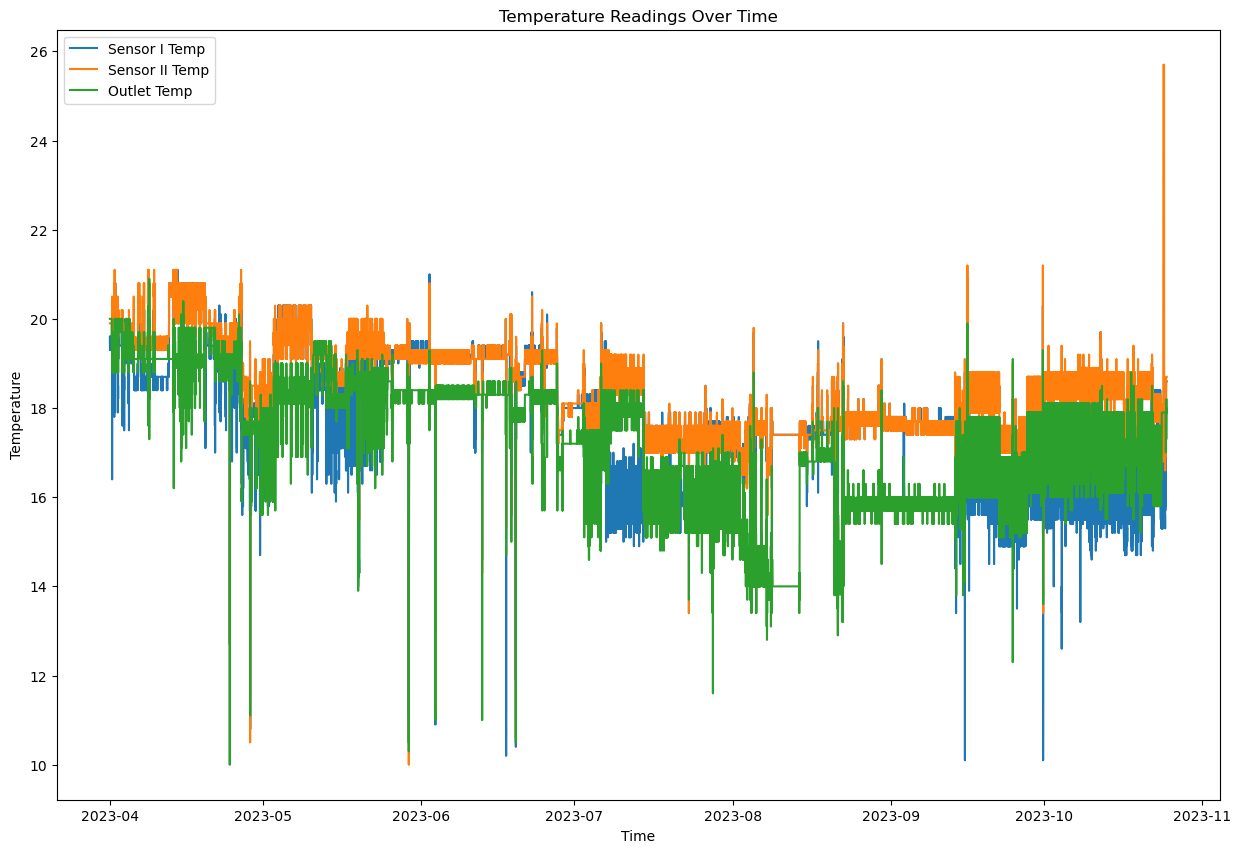

In [4]:
plt.figure(figsize=(15, 10))

plt.plot(FINAL_DF['Timestamp'],FINAL_DF['SENSOR_I_TEMP'], label='Sensor I Temp')
plt.plot(FINAL_DF['Timestamp'],FINAL_DF['SENSOR_II_TEMP'], label='Sensor II Temp')
plt.plot(FINAL_DF['Timestamp'],FINAL_DF['OUTLET_TEMP'], label='Outlet Temp')

plt.title('Temperature Readings Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.legend()
plt.show()

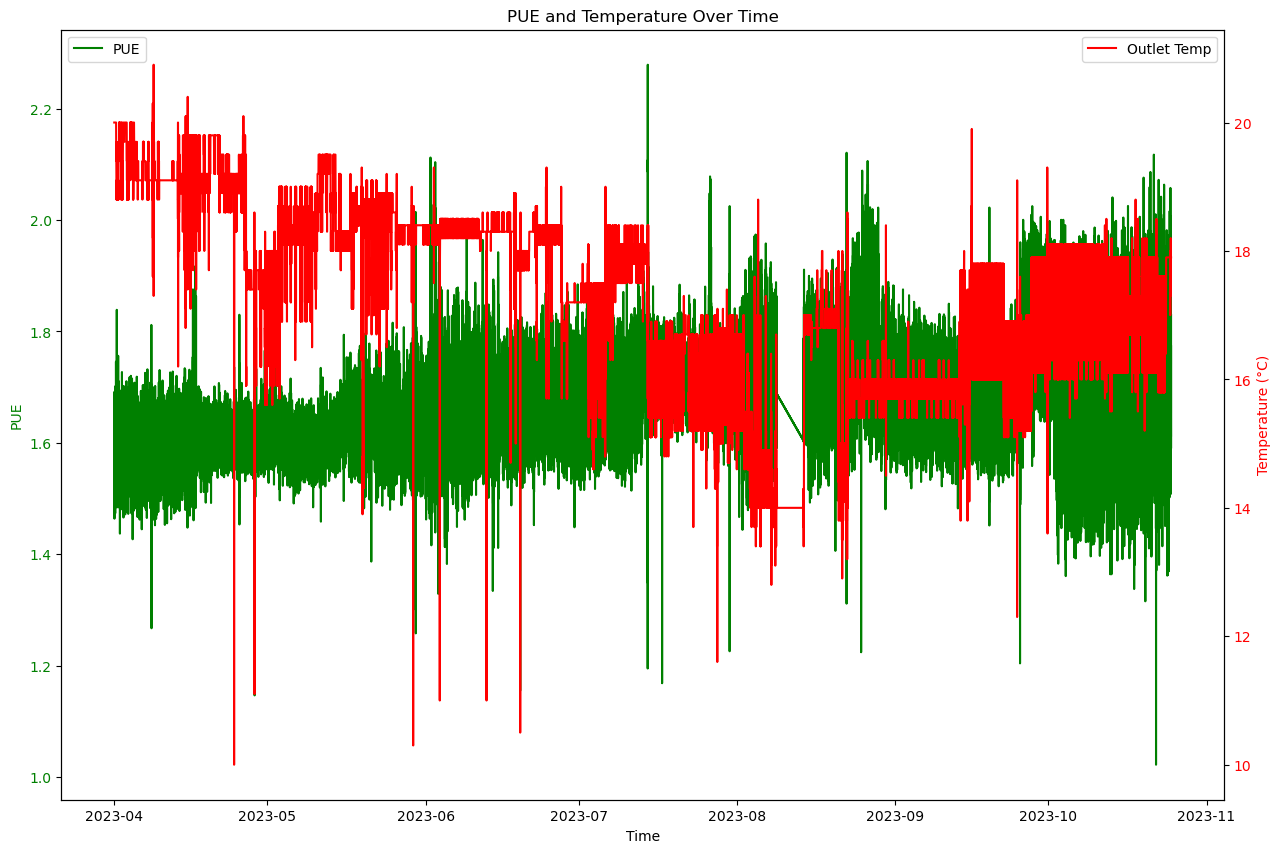

In [5]:
plt.figure(figsize=(15, 10))
ax1 = plt.gca() 
ax2 = ax1.twinx()  

ax1.plot(FINAL_DF['Timestamp'], FINAL_DF['PUE'], label='PUE', color='g')
ax1.set_xlabel('Time')
ax1.set_ylabel('PUE', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', color='r')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('PUE and Temperature Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

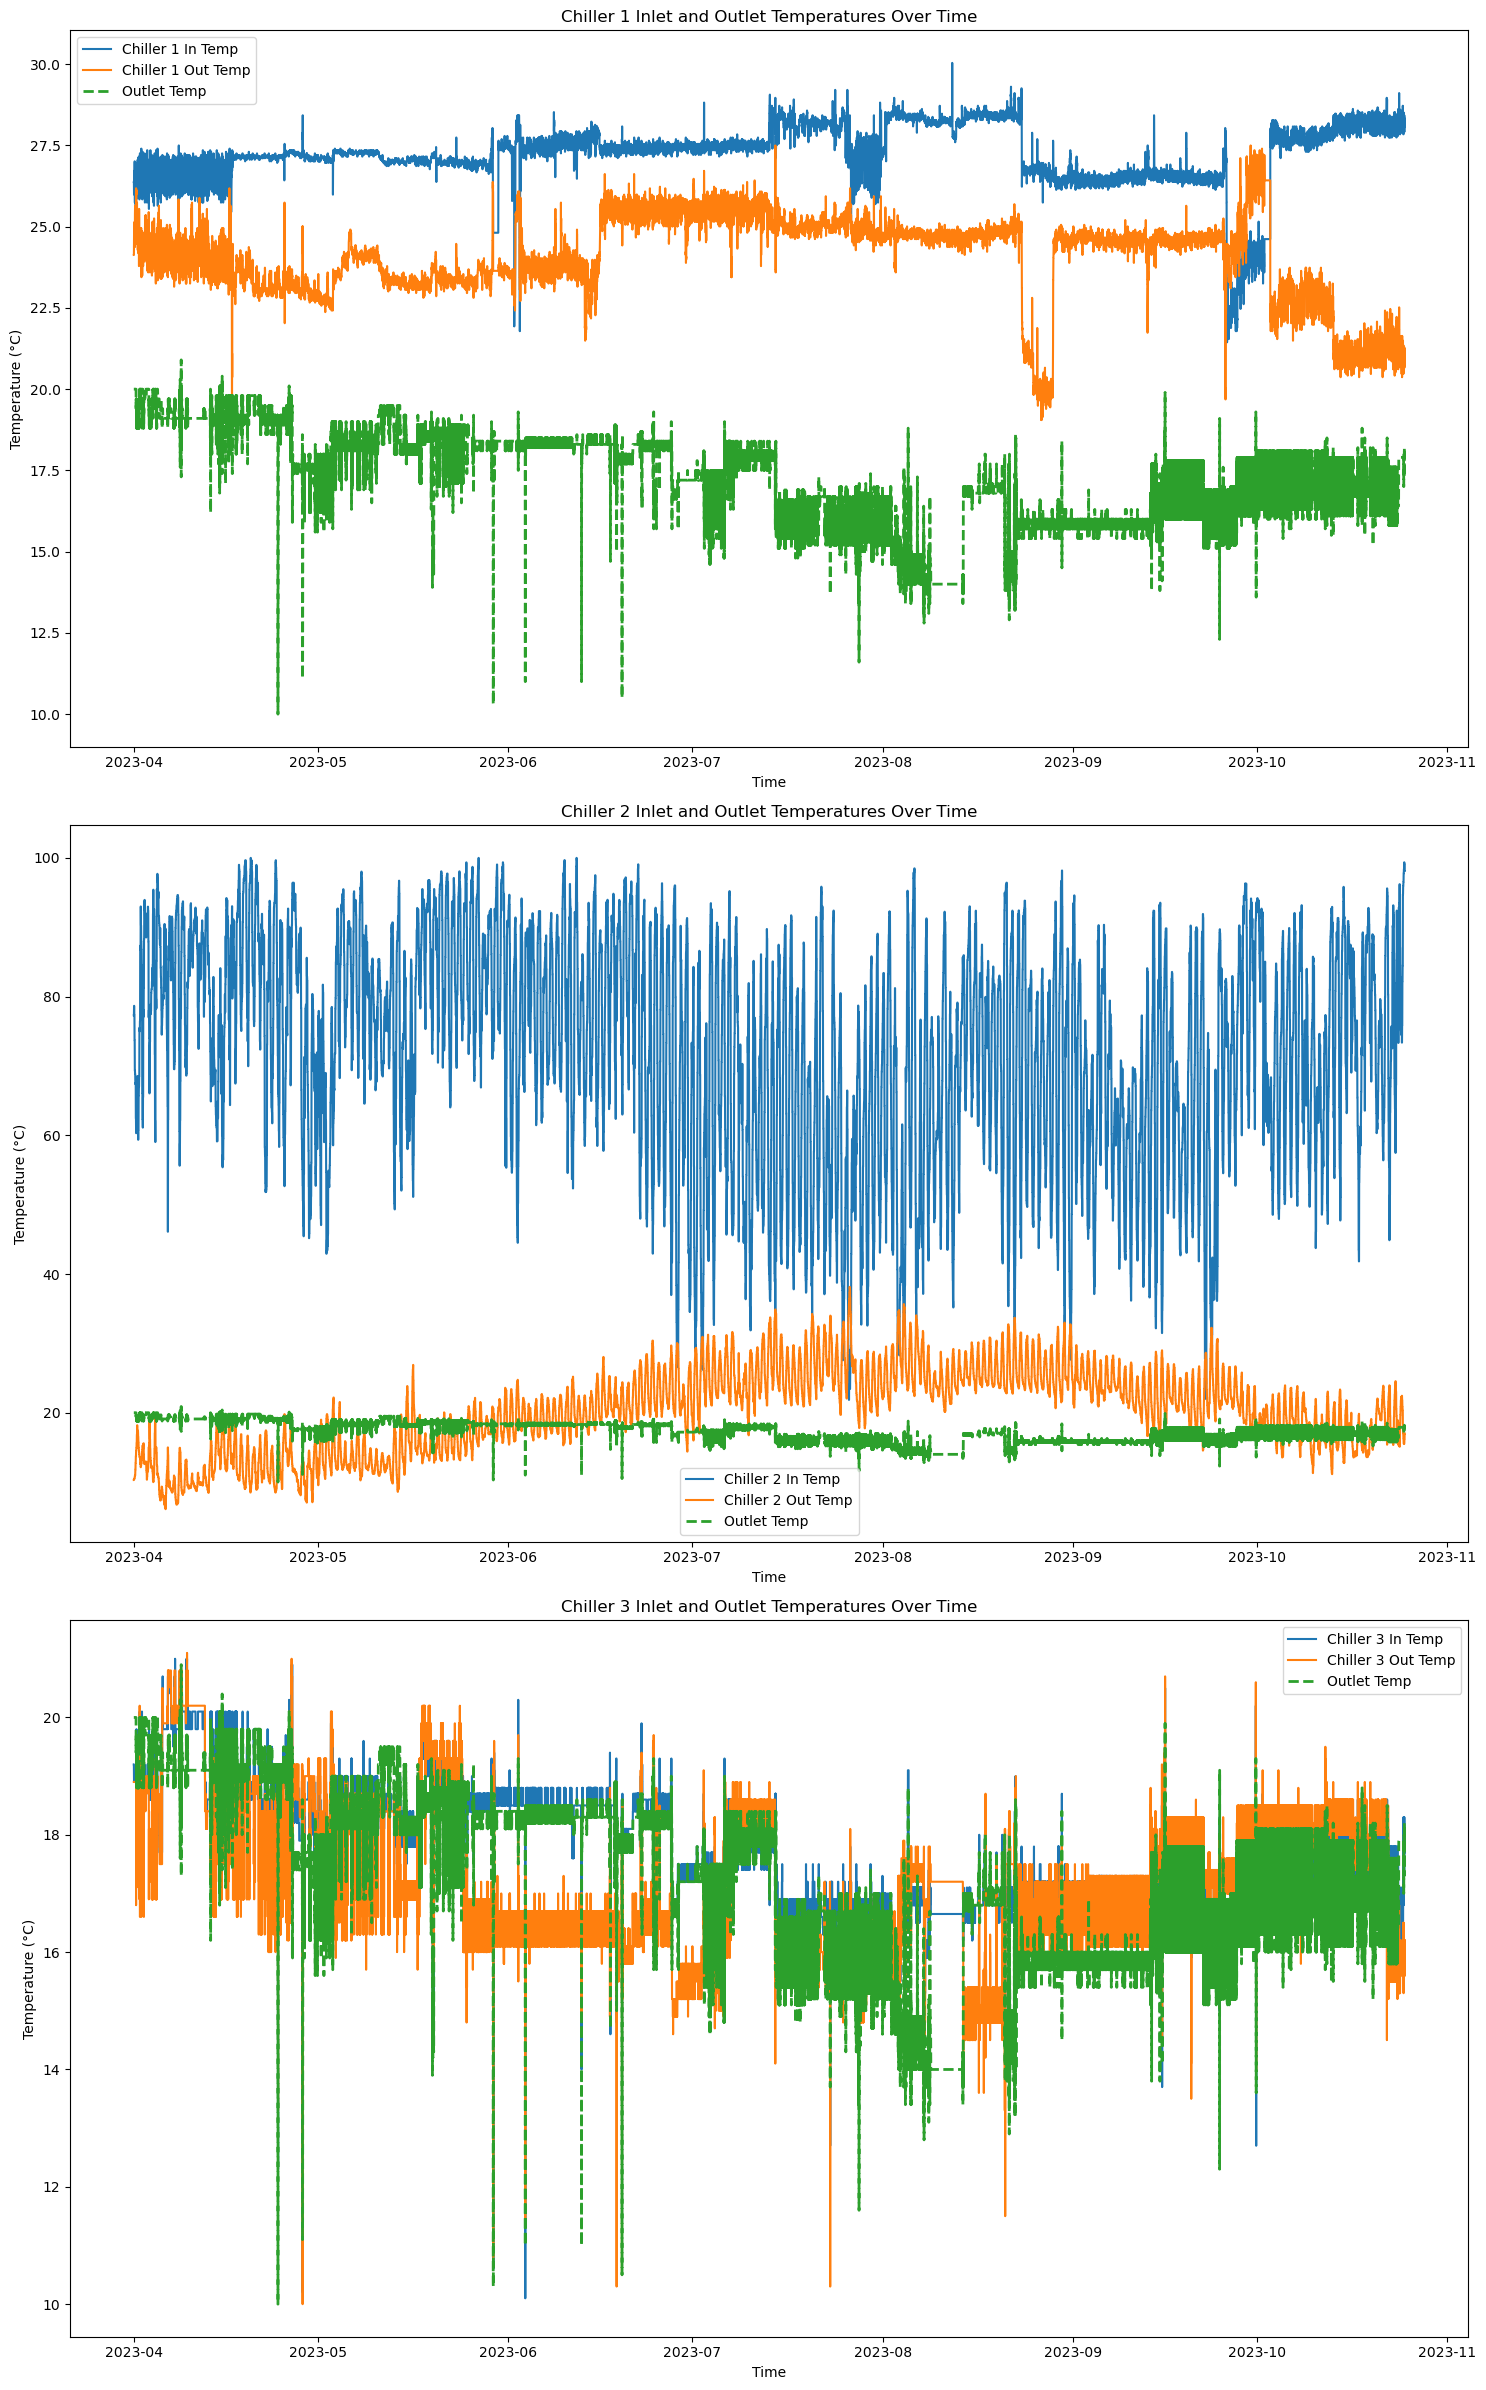

In [6]:
plt.figure(figsize=(15, 24))  

# Subplot for Chiller 1 Temperatures
plt.subplot(3, 1, 1) 
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH1_GIRIS_SIC'], label='Chiller 1 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH1_CIKIS_SIC'], label='Chiller 1 Out Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linewidth=2, linestyle='--')
plt.title('Chiller 1 Inlet and Outlet Temperatures Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Subplot for Chiller 2 Temperatures
plt.subplot(3, 1, 2) 
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH2_GIRIS_SIC'], label='Chiller 2 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH2_CIKIS_SIC'], label='Chiller 2 Out Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linewidth=2, linestyle='--')
plt.title('Chiller 2 Inlet and Outlet Temperatures Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Subplot for Chiller 3 Temperatures
plt.subplot(3, 1, 3)  
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH3_GIRIS_SIC'], label='Chiller 3 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH3_CIKIS_SIC'], label='Chiller 3 Out Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linewidth=2, linestyle='--')
plt.title('Chiller 3 Inlet and Outlet Temperatures Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

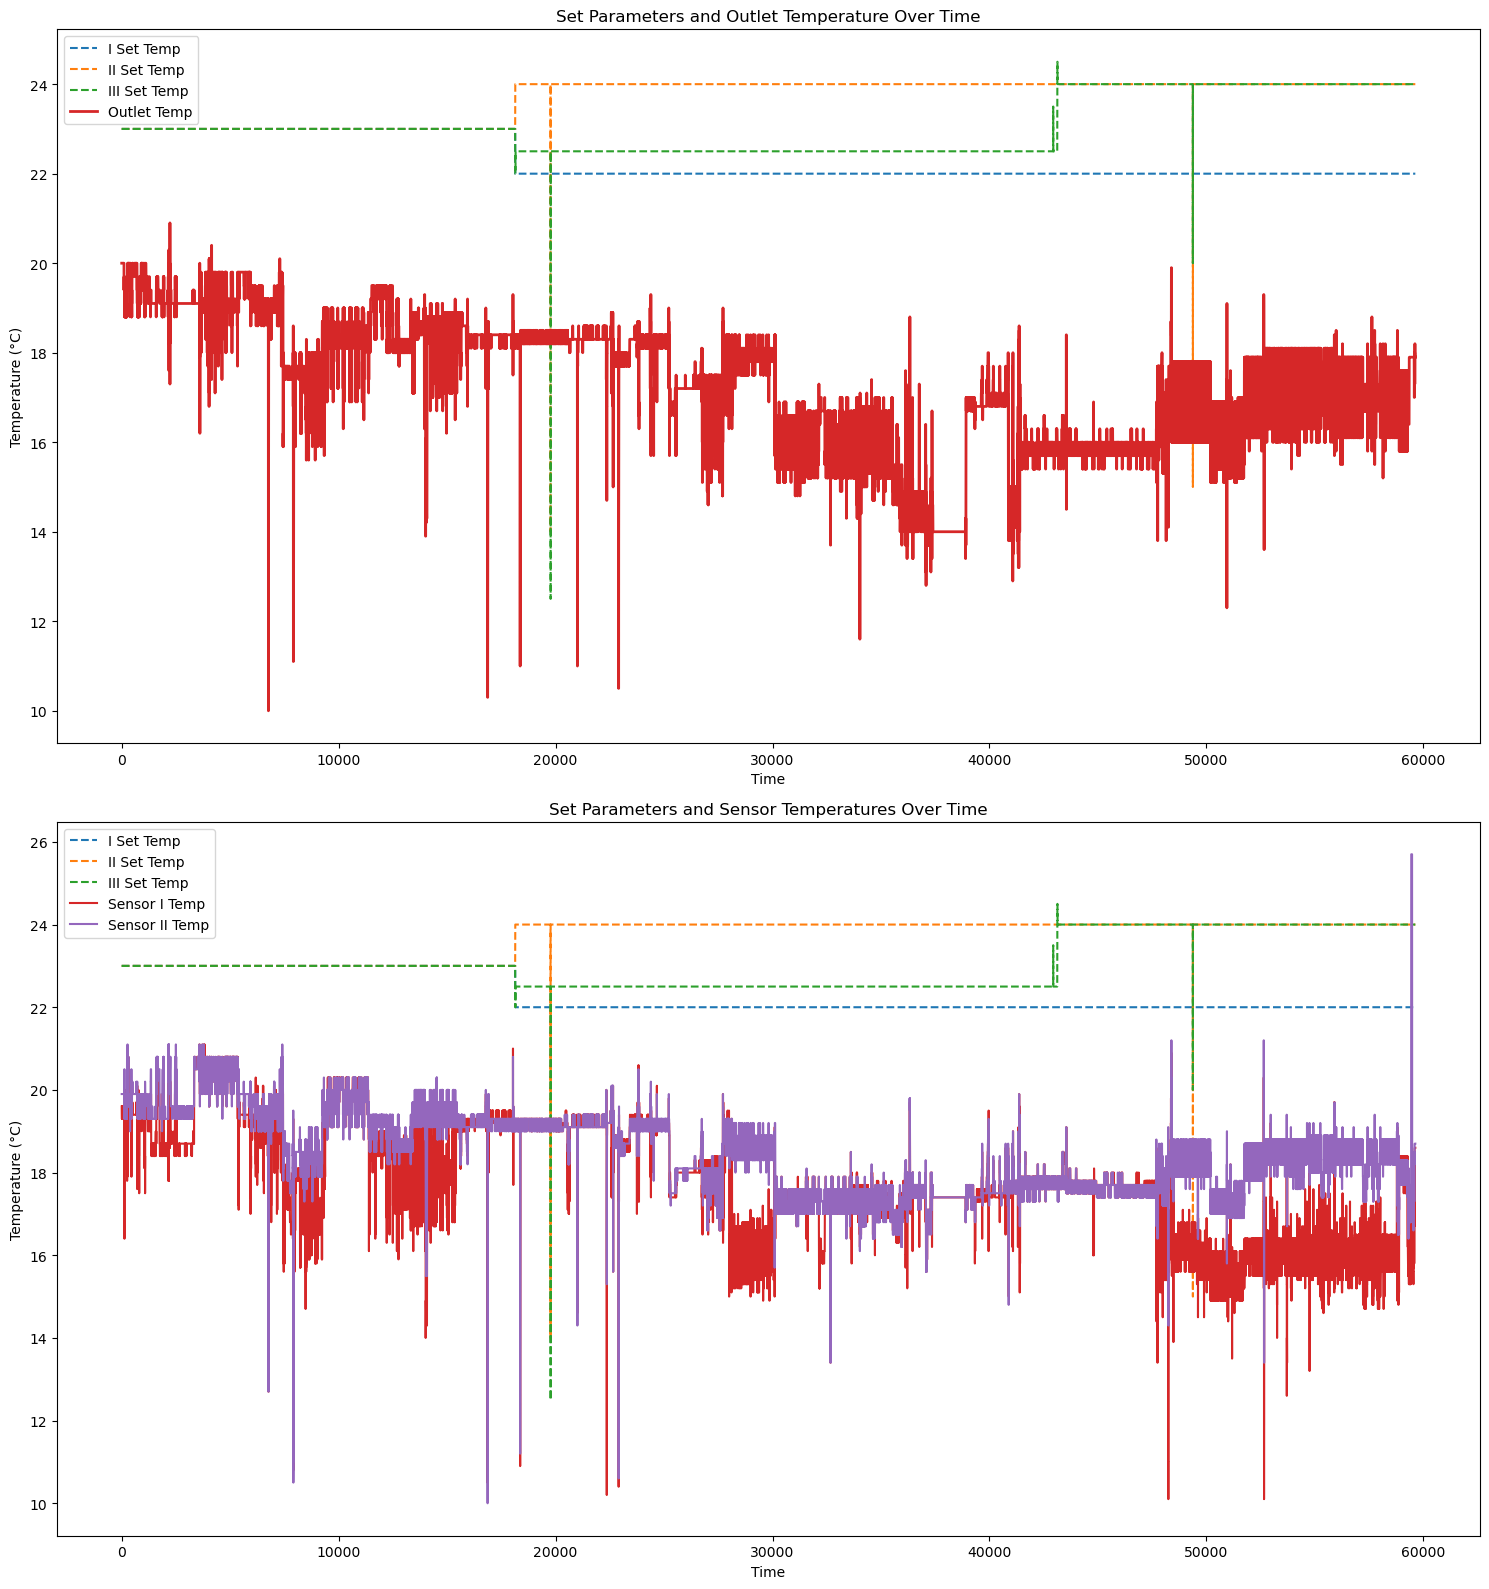

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

ax1.plot(FINAL_DF['I_SIC_SET'], label='I Set Temp', linestyle='--')
ax1.plot(FINAL_DF['II_SIC_SET'], label='II Set Temp', linestyle='--')
ax1.plot(FINAL_DF['III_SIC_SET'], label='III Set Temp', linestyle='--')
ax1.plot(FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linewidth=2)
ax1.set_title('Set Parameters and Outlet Temperature Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()

ax2.plot(FINAL_DF['I_SIC_SET'], label='I Set Temp', linestyle='--')
ax2.plot(FINAL_DF['II_SIC_SET'], label='II Set Temp', linestyle='--')
ax2.plot(FINAL_DF['III_SIC_SET'], label='III Set Temp', linestyle='--')
ax2.plot(FINAL_DF['SENSOR_I_TEMP'], label='Sensor I Temp')
ax2.plot(FINAL_DF['SENSOR_II_TEMP'], label='Sensor II Temp')
ax2.set_title('Set Parameters and Sensor Temperatures Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature (°C)')
ax2.legend()

plt.tight_layout()
plt.show()

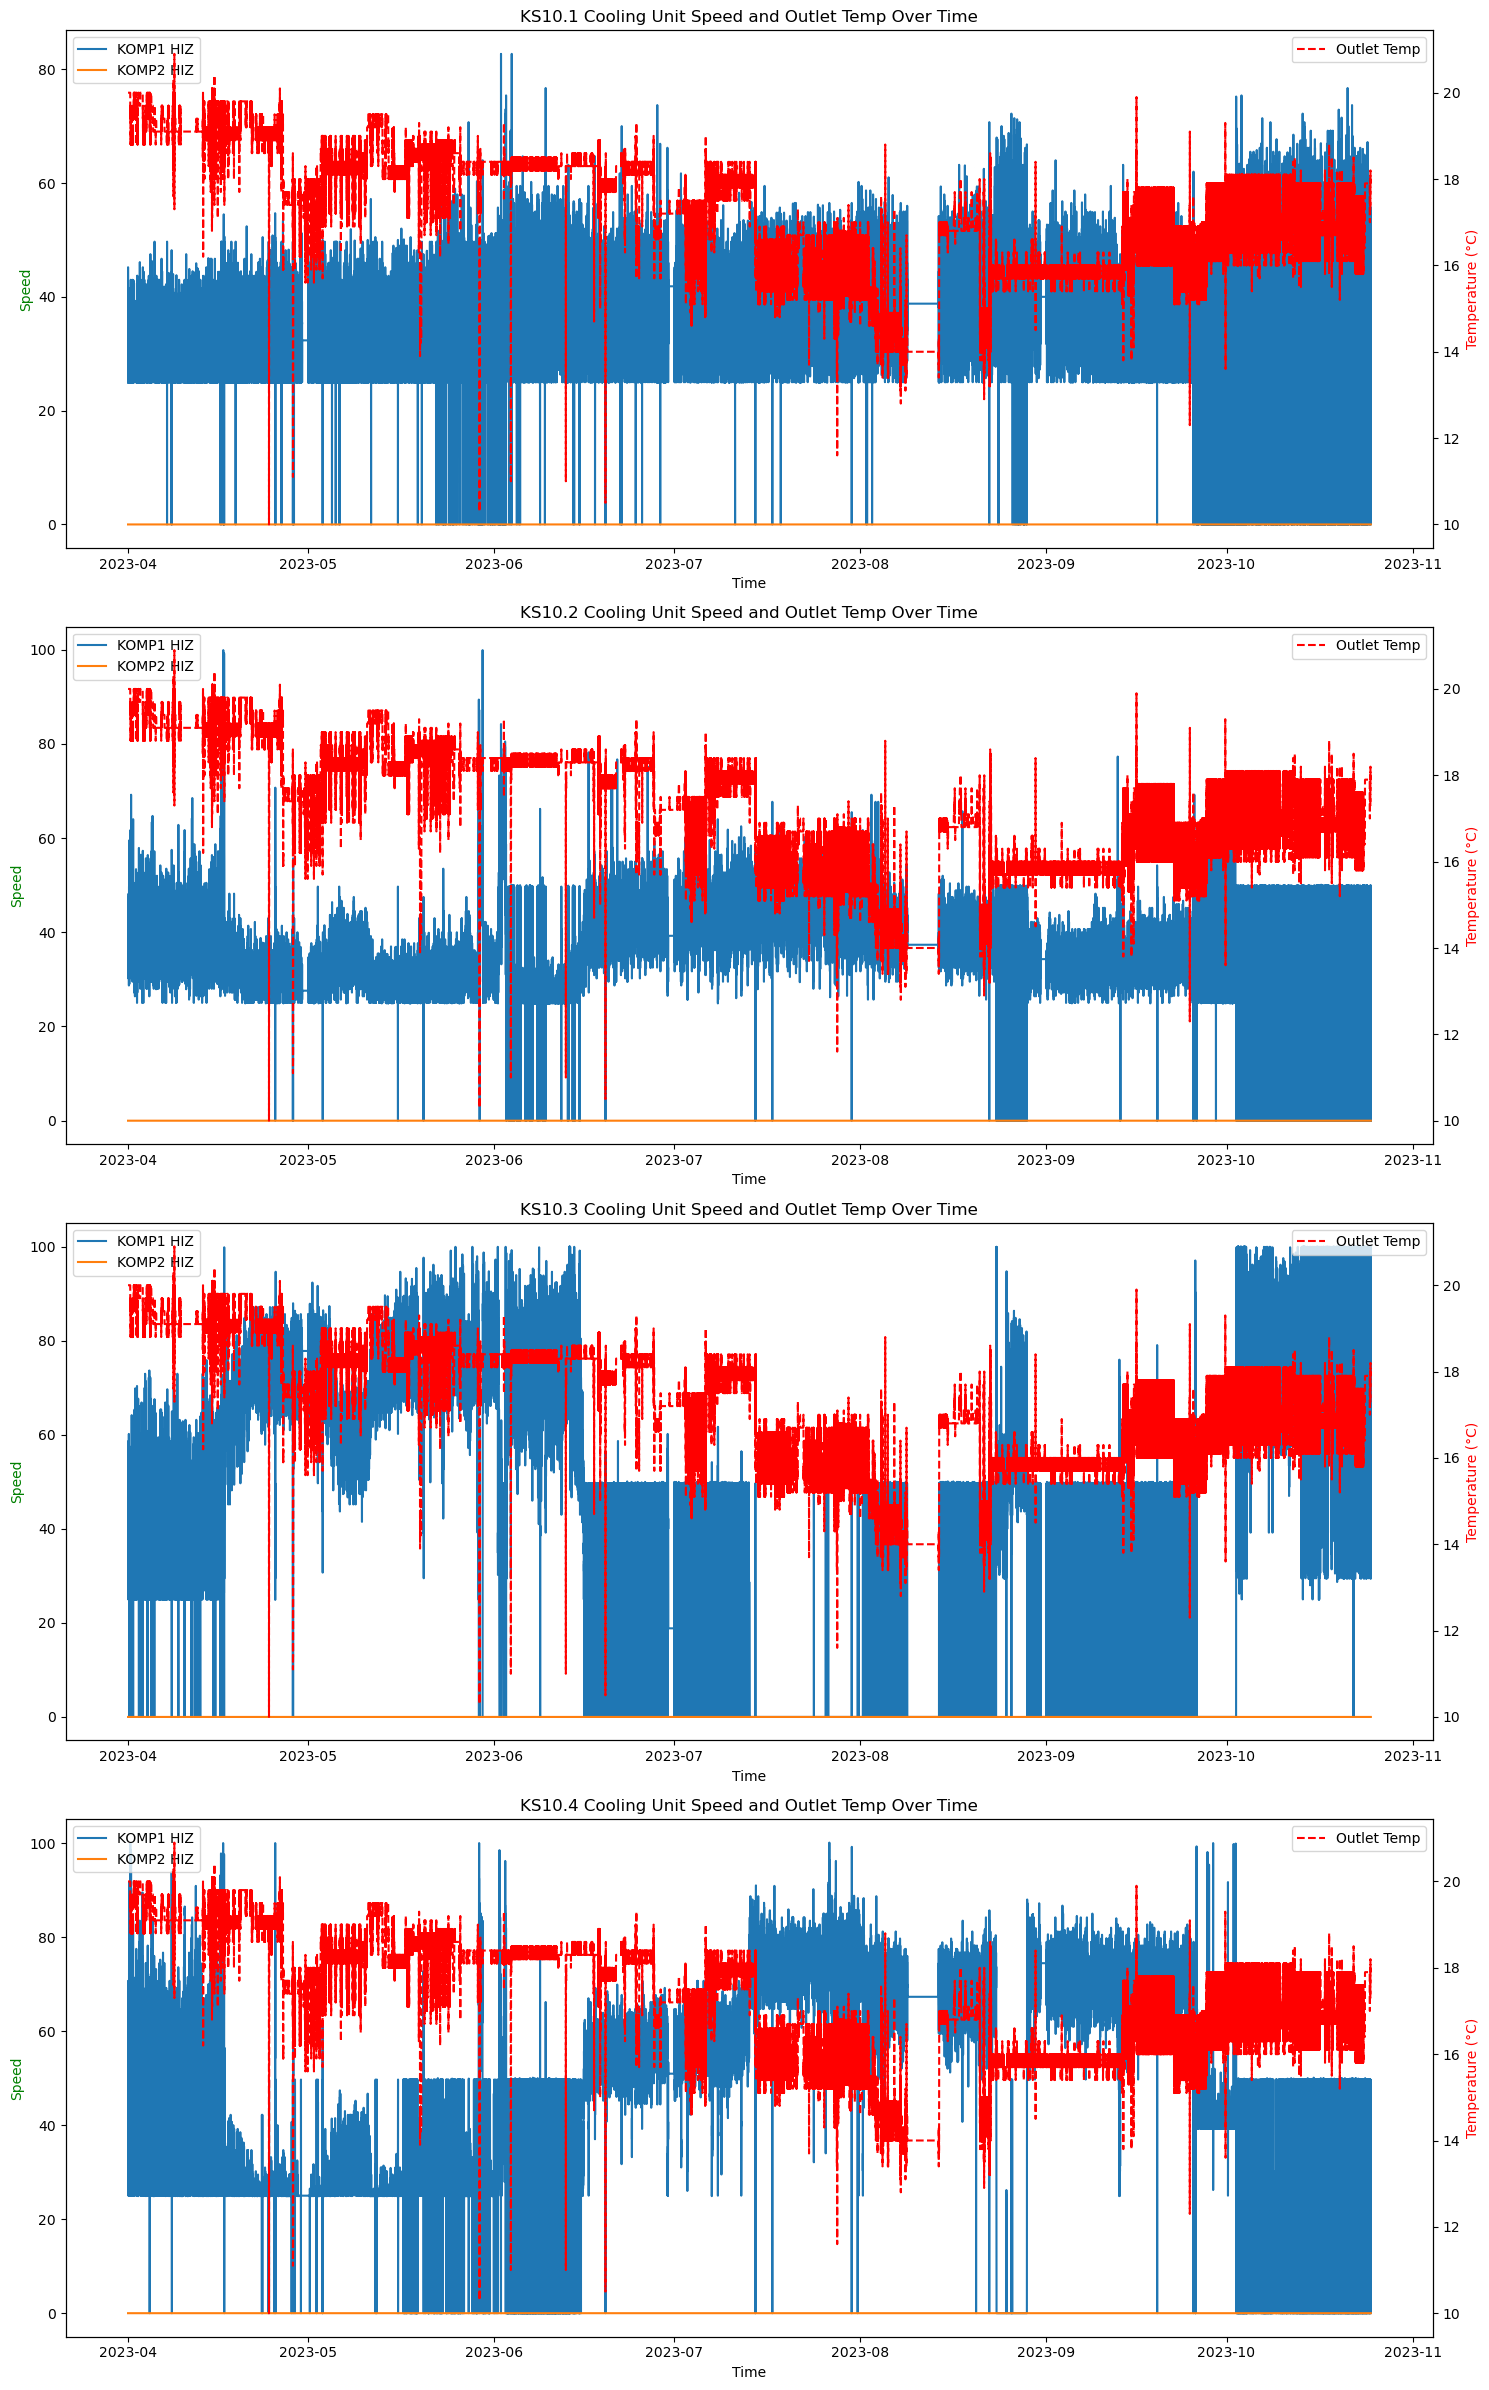

In [8]:
plt.figure(figsize=(15, 24))  

ax1_1 = plt.subplot(4, 1, 1)
ax2_1 = ax1_1.twinx()
ax1_1.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP1_HIZ'], label='KOMP1 HIZ')
ax1_1.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP2_HIZ'], label='KOMP2 HIZ')
ax2_1.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linestyle='--', color='r')
ax1_1.set_title('KS10.1 Cooling Unit Speed and Outlet Temp Over Time')
ax1_1.set_xlabel('Time')
ax1_1.set_ylabel('Speed', color='g')
ax2_1.set_ylabel('Temperature (°C)', color='r')
ax1_1.legend(loc='upper left')
ax2_1.legend(loc='upper right')

# KS10.2 Cooling Unit Speed and Outlet Temp Over Time
ax1_2 = plt.subplot(4, 1, 2)
ax2_2 = ax1_2.twinx()
ax1_2.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP1_HIZ'], label='KOMP1 HIZ')
ax1_2.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP2_HIZ'], label='KOMP2 HIZ')
ax2_2.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linestyle='--', color='r')
ax1_2.set_title('KS10.2 Cooling Unit Speed and Outlet Temp Over Time')
ax1_2.set_xlabel('Time')
ax1_2.set_ylabel('Speed', color='g')
ax2_2.set_ylabel('Temperature (°C)', color='r')
ax1_2.legend(loc='upper left')
ax2_2.legend(loc='upper right')

# KS10.3 Cooling Unit Speed and Outlet Temp Over Time
ax1_3 = plt.subplot(4, 1, 3)
ax2_3 = ax1_3.twinx()
ax1_3.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP1_HIZ'], label='KOMP1 HIZ')
ax1_3.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP2_HIZ'], label='KOMP2 HIZ')
ax2_3.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linestyle='--', color='r')
ax1_3.set_title('KS10.3 Cooling Unit Speed and Outlet Temp Over Time')
ax1_3.set_xlabel('Time')
ax1_3.set_ylabel('Speed', color='g')
ax2_3.set_ylabel('Temperature (°C)', color='r')
ax1_3.legend(loc='upper left')
ax2_3.legend(loc='upper right')

# KS10.4 Cooling Unit Speed and Outlet Temp Over Time
ax1_4 = plt.subplot(4, 1, 4)
ax2_4 = ax1_4.twinx()
ax1_4.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP1_HIZ'], label='KOMP1 HIZ')
ax1_4.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP2_HIZ'], label='KOMP2 HIZ')
ax2_4.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp', linestyle='--', color='r')
ax1_4.set_title('KS10.4 Cooling Unit Speed and Outlet Temp Over Time')
ax1_4.set_xlabel('Time')
ax1_4.set_ylabel('Speed', color='g')
ax2_4.set_ylabel('Temperature (°C)', color='r')
ax1_4.legend(loc='upper left')
ax2_4.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [9]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
HOURS = ['hour_' + str(hour) for hour in range(24)]
MONTHS = ['month_' + str(month) for month in range(4, 11)]
column_names = ['Timestamp', 'PUE',
                    
                    'I_KOMP1_HIZ', 
                    #'I_KOMP1_SAAT',
                    'I_KOMP2_HIZ', 
                    #'I_KOMP2_SAAT',
                    #'I_NEM_SET','I_SIC_SET', 
                    
                    'II_KOMP1_HIZ', 
                    #'II_KOMP1_SAAT',
                    'II_KOMP2_HIZ',
                    #'II_KOMP2_SAAT',
                    #'II_NEM_SET','II_SIC_SET', 
                    
                    'III_KOMP1_HIZ', 
                    #'III_KOMP1_SAAT',
                    'III_KOMP2_HIZ', 
                    #'III_KOMP2_SAAT',
                    #'III_NEM_SET','III_SIC_SET', 
                    
                    'IV_KOMP1_HIZ', 
                    #'IV_KOMP1_SAAT',
                    'IV_KOMP2_HIZ', 
                    #'IV_KOMP2_SAAT',
                    #'IV_NEM_SET',
                    
                    'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC',
                    'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC', 
                    'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
                    
                    'SENSOR_I_TEMP', 'SENSOR_II_TEMP', 
                    'OUTLET_TEMP', 'OUTLET_HUMIDITY'] + DAYS + HOURS + MONTHS

In [10]:
FINAL_DF = FINAL_DF.loc[:, column_names]

In [11]:
# add extra columns

#FINAL_DF["PUE_lag_" + str(1)] = FINAL_DF["PUE"].shift(1)
FINAL_DF["PUE_lag_one_day"] = FINAL_DF["PUE"].shift(24*12)
FINAL_DF["PUE_lag_one_week"] = FINAL_DF["PUE"].shift(7*24*12)


FINAL_DF.dropna(inplace=True)
FINAL_DF.reset_index(drop=True, inplace=True)
FINAL_DF

,Timestamp,PUE,I_KOMP1_HIZ,I_KOMP2_HIZ,II_KOMP1_HIZ,II_KOMP2_HIZ,III_KOMP1_HIZ,III_KOMP2_HIZ,IV_KOMP1_HIZ,IV_KOMP2_HIZ,...,hour_23,month_4,month_5,month_6,month_7,month_8,month_9,month_10,PUE_lag_one_day,PUE_lag_one_week
0,2023-04-08 00:00:00,1.570328,27.900000,0.0,30.900000,0.0,25.000000,0.0,58.700001,0.0,...,0,1,0,0,0,0,0,0,1.658846,1.593893
1,2023-04-08 00:05:00,1.638140,33.200001,0.0,38.500000,0.0,35.500000,0.0,62.500000,0.0,...,0,1,0,0,0,0,0,0,1.546095,1.623764
2,2023-04-08 00:10:00,1.570857,31.000000,0.0,40.700001,0.0,39.200001,0.0,53.099998,0.0,...,0,1,0,0,0,0,0,0,1.588571,1.634981
3,2023-04-08 00:15:00,1.644509,35.400002,0.0,40.700001,0.0,27.200001,0.0,61.000000,0.0,...,0,1,0,0,0,0,0,0,1.570722,1.608970
4,2023-04-08 00:20:00,1.590440,25.000000,0.0,34.700001,0.0,26.400000,0.0,64.699997,0.0,...,0,1,0,0,0,0,0,0,1.530134,1.554008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57609,2023-10-25 00:45:00,1.611181,26.400000,0.0,0.000000,0.0,39.200001,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1,1.566098,1.598934
57610,2023-10-25 00:50:00,1.831158,39.200001,0.0,49.700001,0.0,29.400000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1,1.681818,1.660297
57611,2023-10-25 00:55:00,1.627907,44.000000,0.0,0.000000,0.0,29.400000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1,1.637288,1.782203
57612,2023-10-25 01:00:00,1.590126,0.000000,0.0,29.400000,0.0,39.200001,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1,1.822105,1.861652


In [12]:
formula_x = "np.log(PUE-1)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    formula_y += FINAL_DF.columns[i] + " + "
    
formula_y = formula_y[:-3]

formula = formula_x + " ~ " + formula_y
print(formula)

np.log(PUE-1) ~ I_KOMP1_HIZ + I_KOMP2_HIZ + II_KOMP1_HIZ + II_KOMP2_HIZ + III_KOMP1_HIZ + III_KOMP2_HIZ + IV_KOMP1_HIZ + IV_KOMP2_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + SENSOR_I_TEMP + SENSOR_II_TEMP + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + PUE_lag_one_day + PUE_lag_one_week


<h2>Train / Test Splits</h2>

In [13]:
train, test = train_test_split(FINAL_DF, test_size=0.2, random_state=42)

<h2>OLS</h2>

In [14]:
reg_model = sm.ols(formula=formula, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(PUE - 1)   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     1370.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:24:27   Log-Likelihood:                 52377.
No. Observations:               46091   AIC:                        -1.046e+05
Df Residuals:                   46039   BIC:                        -1.042e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1020      0.027     40.541      0.000       1.049       1.155
I_KOMP1_HIZ          0.0035   3.84e-05     92.150      0.000       0.003       0.004
I_KOMP2_HIZ      -5.821e-14   1.44e-15    -40.528      0.000    -6.1e-14   -5.54e-14
II_KOMP1_HIZ         0.0045   3.49e-05    129.124      0.000       0.004       0.005
II_KOMP2_HIZ      1.707e-13   4.21e-15     40.505      0.000    1.62e-13    1.79e-13
III_KOMP1_HIZ        0.0023   2.29e-05    102.005      0.000       0.002       0.002
III_KOMP2_HIZ    -2.521e-14   6.28e-16    -40.157      0.000   -2.64e-14    -2.4e-14
IV_KOMP1_HIZ         0.0023   3.06e-05     74.688      0.000       0.002       0.002
IV_KOMP2_HIZ     -1.134e-14   2.82e-16    -40.142      0.000   -1.19e-14   -1.08e-14
CH1_CIKIS_SIC       -0.0292      0.000    -59.163      0.000      -0.030      -0.028
CH1_GIRIS_SIC       -0.0591      0.001   -113.236      0.000      -0.060      -0.058
CH2_CIKIS_SIC        0.0107      0.000     63.774      0.000       0.010       0.011
CH2_GIRIS_SIC        0.0012   3.86e-05     32.389      0.000       0.001       0.001
CH3_CIKIS_SIC        0.0033      0.001      4.661      0.000       0.002       0.005
CH3_GIRIS_SIC       -0.0125      0.001     -8.760      0.000      -0.015      -0.010
SENSOR_I_TEMP       -0.0065      0.001    -10.034      0.000      -0.008      -0.005
SENSOR_II_TEMP       0.0048      0.001      3.957      0.000       0.002       0.007
OUTLET_TEMP          0.0019      0.001      2.541      0.011       0.000       0.003
OUTLET_HUMIDITY     -0.0067      0.002     -3.591      0.000      -0.010      -0.003
Mon                 -0.0008      0.001     -0.840      0.401      -0.003       0.001
Tue                 -0.0040      0.001     -3.958      0.000      -0.006      -0.002
Wed                 -0.0019      0.001     -1.863      0.062      -0.004    9.84e-05
Thu                 -0.0007      0.001     -0.678      0.498      -0.003       0.001
Fri                  0.0044      0.001      4.344      0.000       0.002       0.006
Sat                  0.0040      0.001      3.982      0.000       0.002       0.006
hour_0               0.0105      0.002      5.471      0.000       0.007       0.014
hour_1               0.0054      0.002      2.773      0.006       0.002       0.009
hour_2               0.0043      0.002      2.215      0.027       0.000       0.008
hour_3               0.0057      0.002      2.949      0.003       0.002       0.010
hour_4               0.0007      0.002      0.345      0.730      -0.003       0.004
hour_5              -0.0039      0.002     -2.034      0.042      -0.008      -0.000
hour_6              -0.0069      0.002     -3.627      0.000      -0.011      -0.003
hour_7              -0.0154      0.002     -8.178      0.000      -0.019      -0.012
hour_8              -0.

In [15]:
y_pred = np.exp(reg_model.predict(train))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0027239416407670216
RMSE Train Set =  0.05219139431713835
MAPE Train Set =  0.02262279158335047


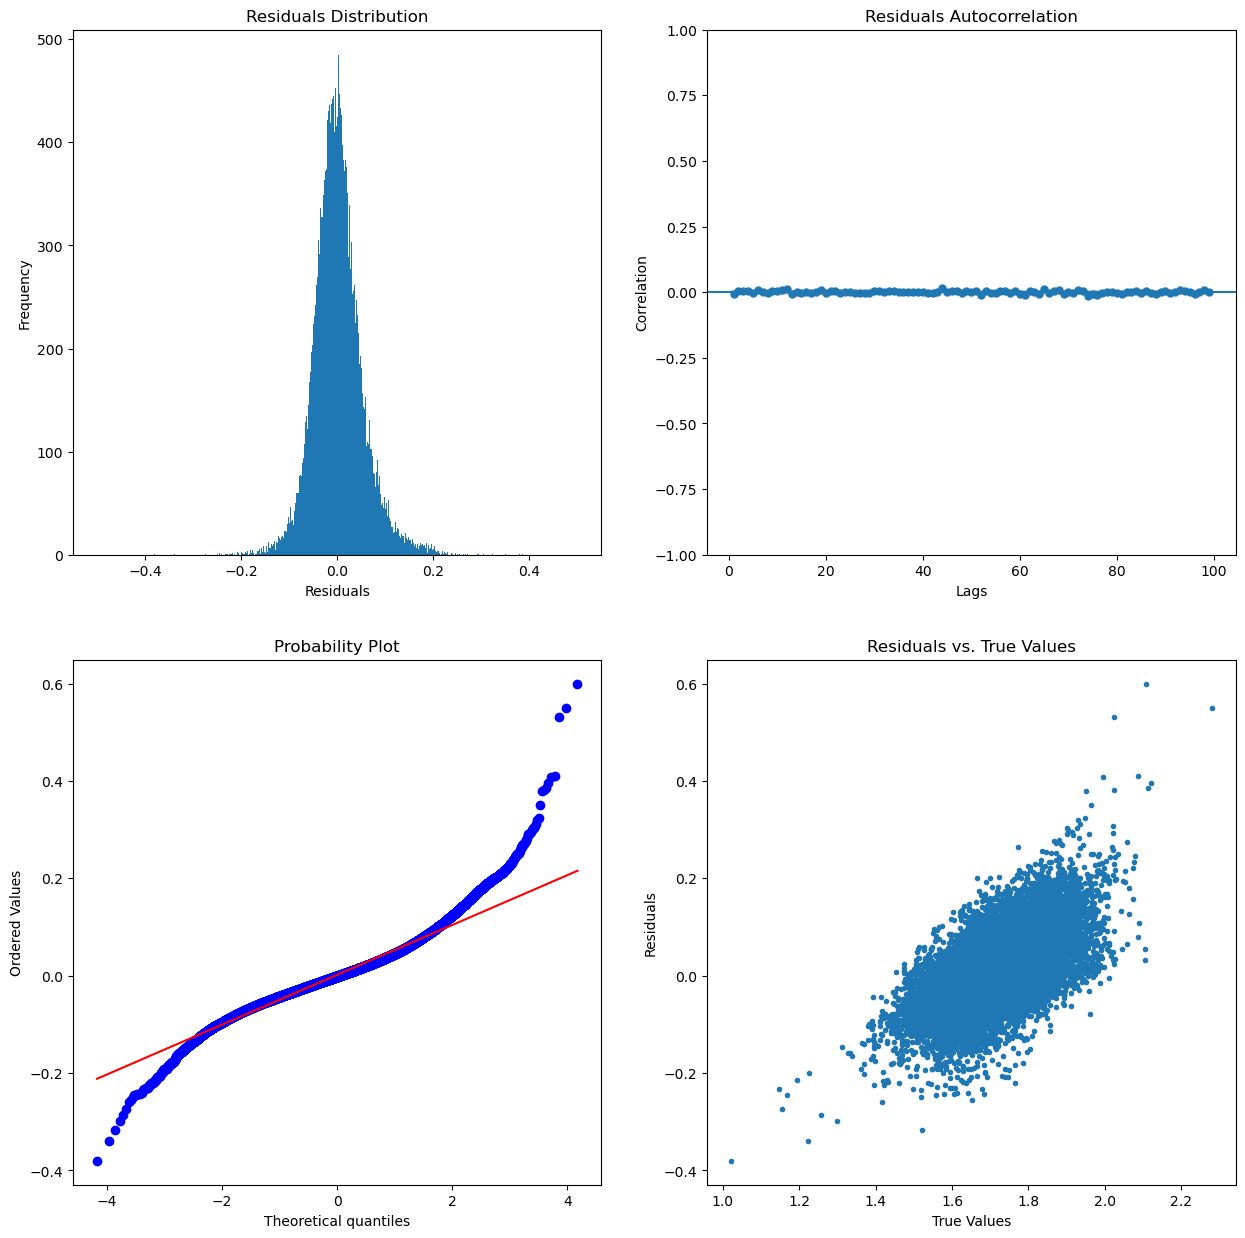

In [16]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [17]:
y_pred = np.exp(reg_model.predict(test))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.00270292477877884
RMSE Test Set =  0.051989660306438236
MAPE Test Set =  0.022496386391502518


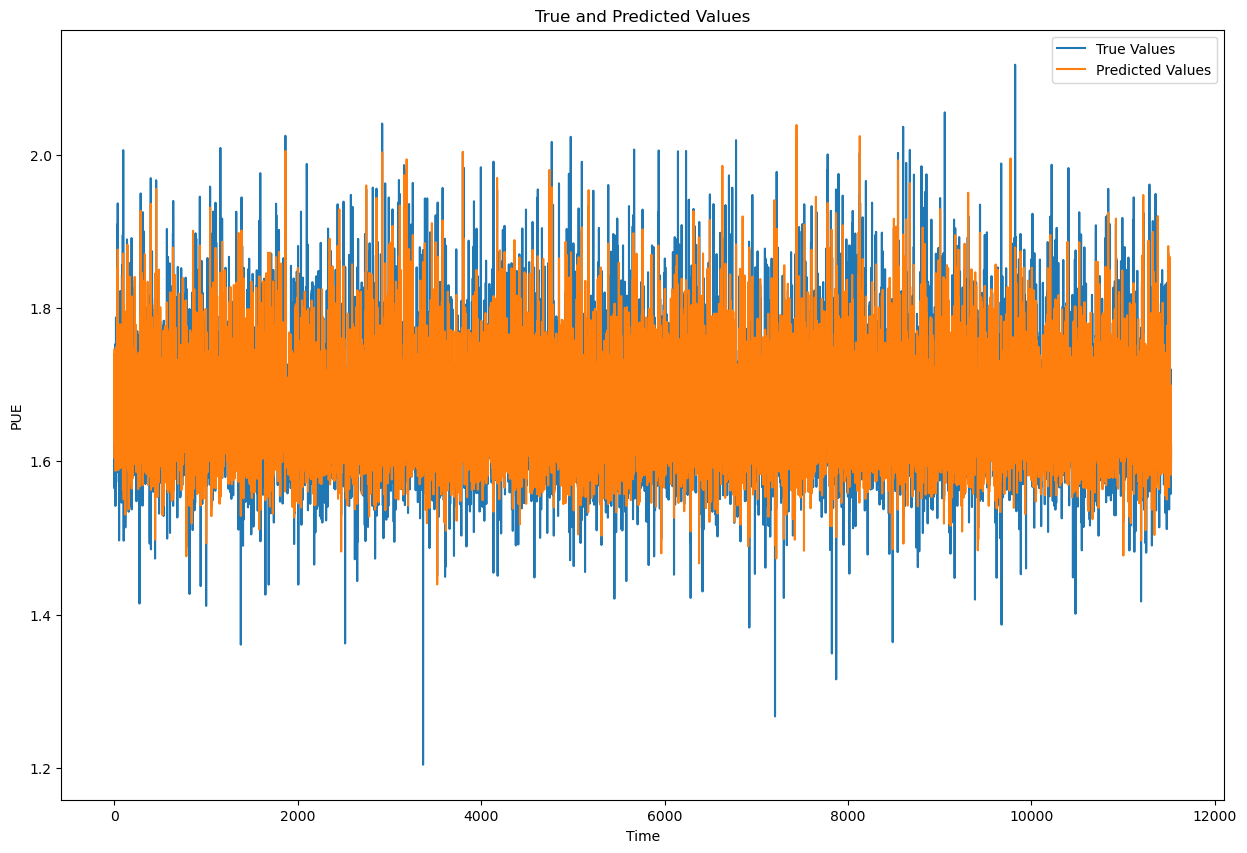

In [18]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

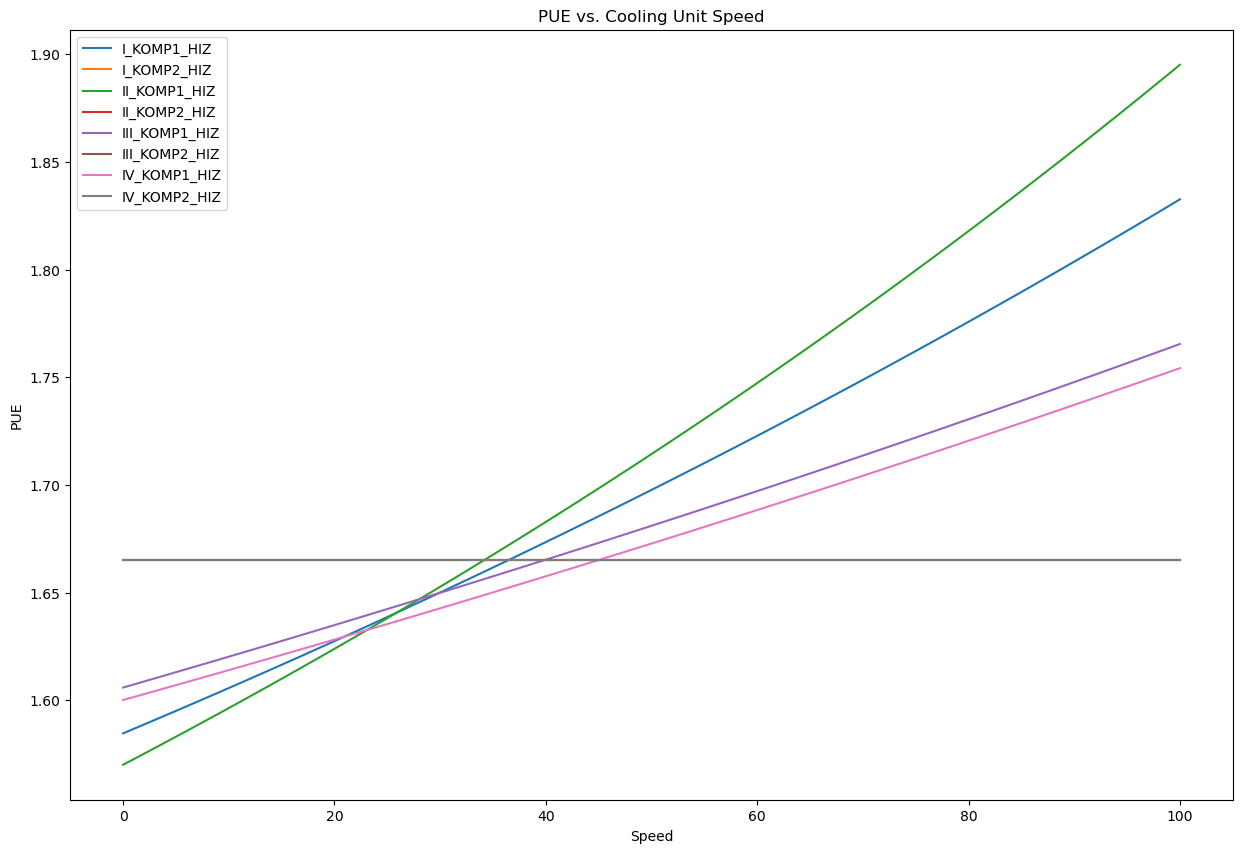

In [83]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[3][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[4][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[5][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[6][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[7][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='I_KOMP2_HIZ')
plt.plot(x,Y[2], label='II_KOMP1_HIZ')
plt.plot(x,Y[3], label='II_KOMP2_HIZ')
plt.plot(x,Y[4], label='III_KOMP1_HIZ')
plt.plot(x,Y[5], label='III_KOMP2_HIZ')
plt.plot(x,Y[6], label='IV_KOMP1_HIZ')
plt.plot(x,Y[7], label='IV_KOMP2_HIZ')
plt.title('PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

<h2>Random Forest</h2>

In [84]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [85]:
rf_model = random_forest(max_features='sqrt')

In [86]:
y_pred = np.exp(rf_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetest)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.00021043931333283015
RMSE Train Set =  0.035095965860207815
MAPE Train Set =  0.006119646599047555


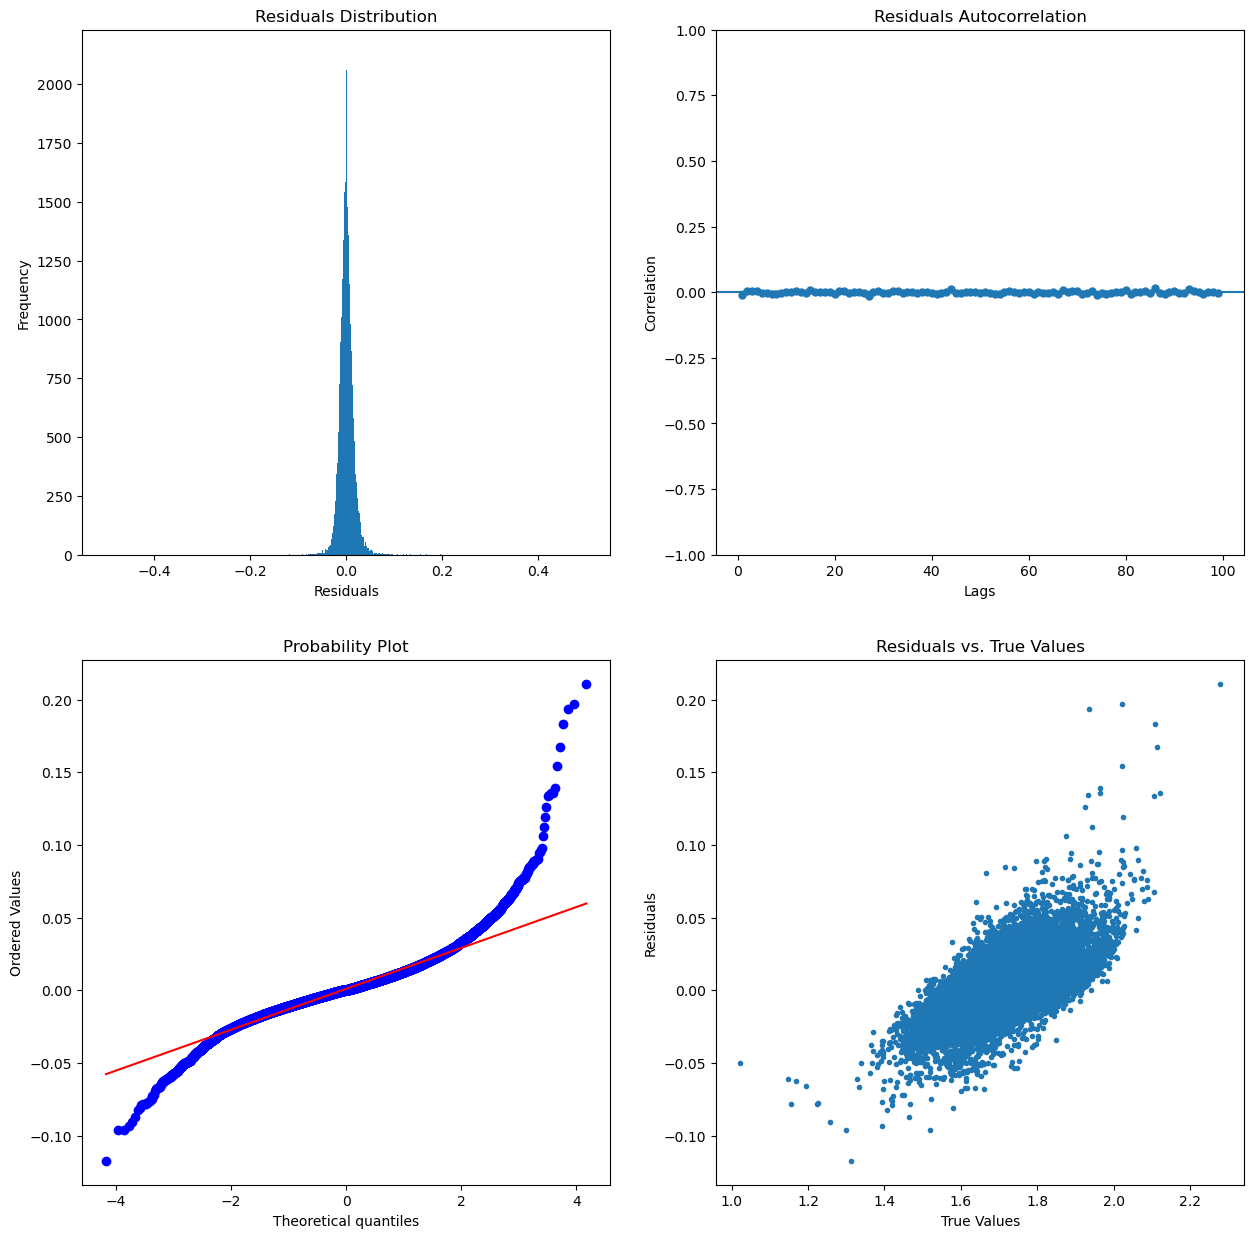

In [87]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [88]:
y_pred = np.exp(rf_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0014684331655333538
RMSE Test Set =  0.03832014046860154
MAPE Test Set =  0.01637417069674152


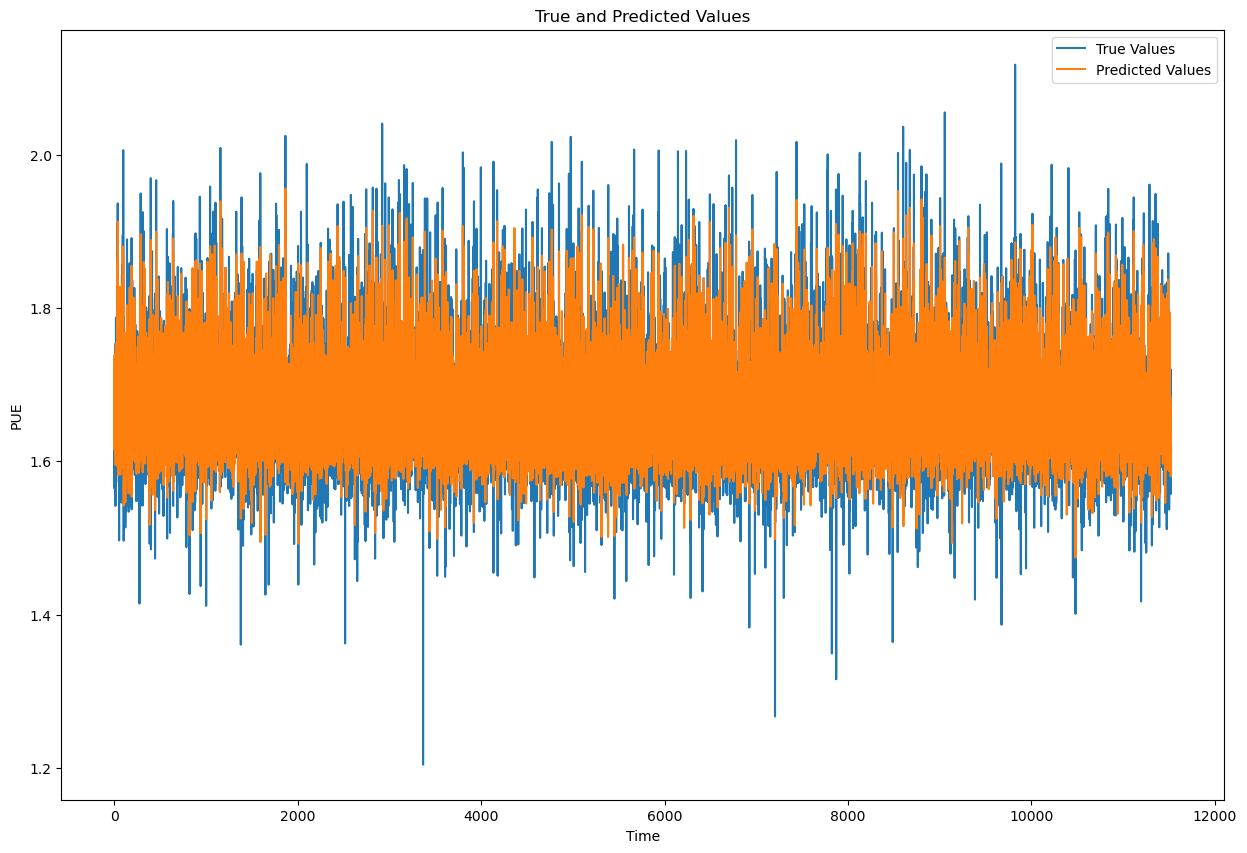

In [89]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

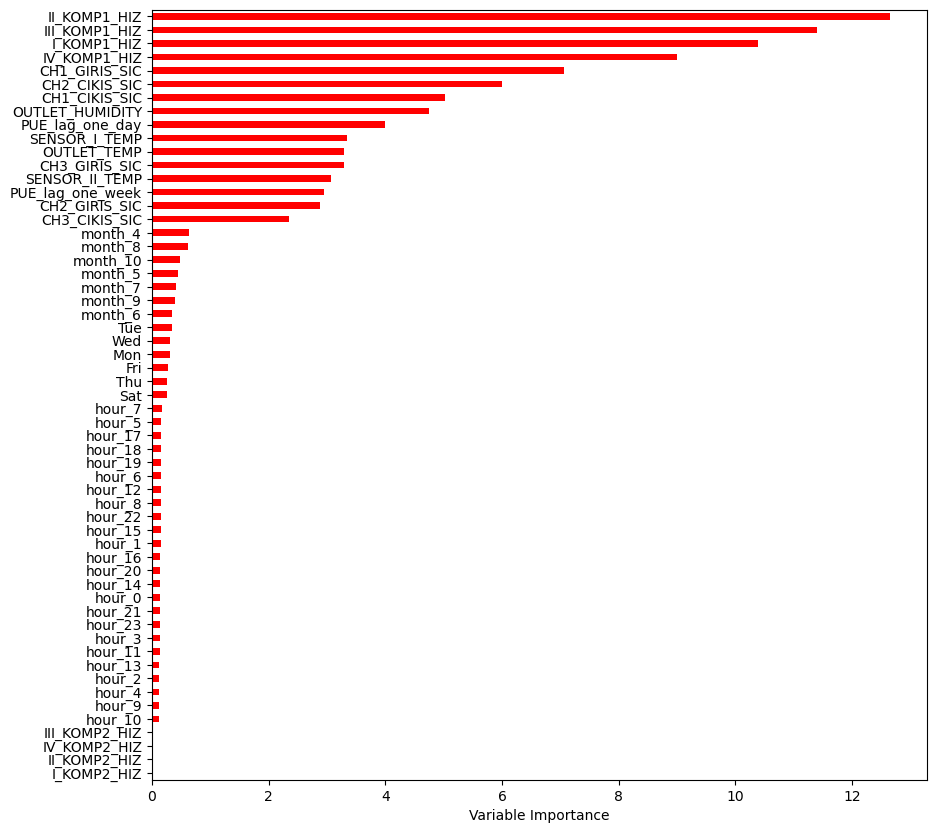

In [90]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

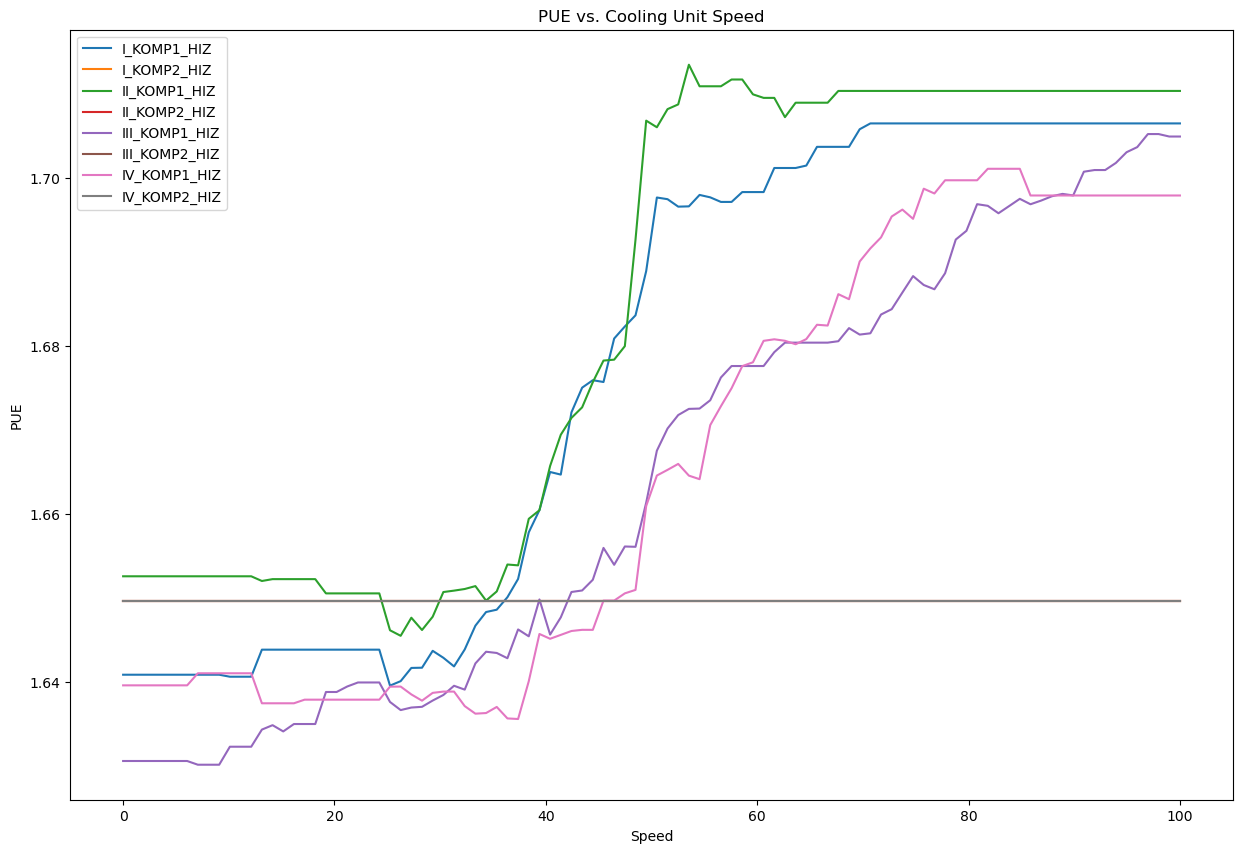

In [93]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[4][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[5][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[6][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[7][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='I_KOMP2_HIZ')
plt.plot(x,Y[2], label='II_KOMP1_HIZ')
plt.plot(x,Y[3], label='II_KOMP2_HIZ')
plt.plot(x,Y[4], label='III_KOMP1_HIZ')
plt.plot(x,Y[5], label='III_KOMP2_HIZ')
plt.plot(x,Y[6], label='IV_KOMP1_HIZ')
plt.plot(x,Y[7], label='IV_KOMP2_HIZ')
plt.title('PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

<h2>Gradient Boosting</h2>

In [94]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [95]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [96]:
y_pred = np.exp(gb_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetest)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.001052614595503736
RMSE Train Set =  0.03832014046860154
MAPE Train Set =  0.01414935973360271


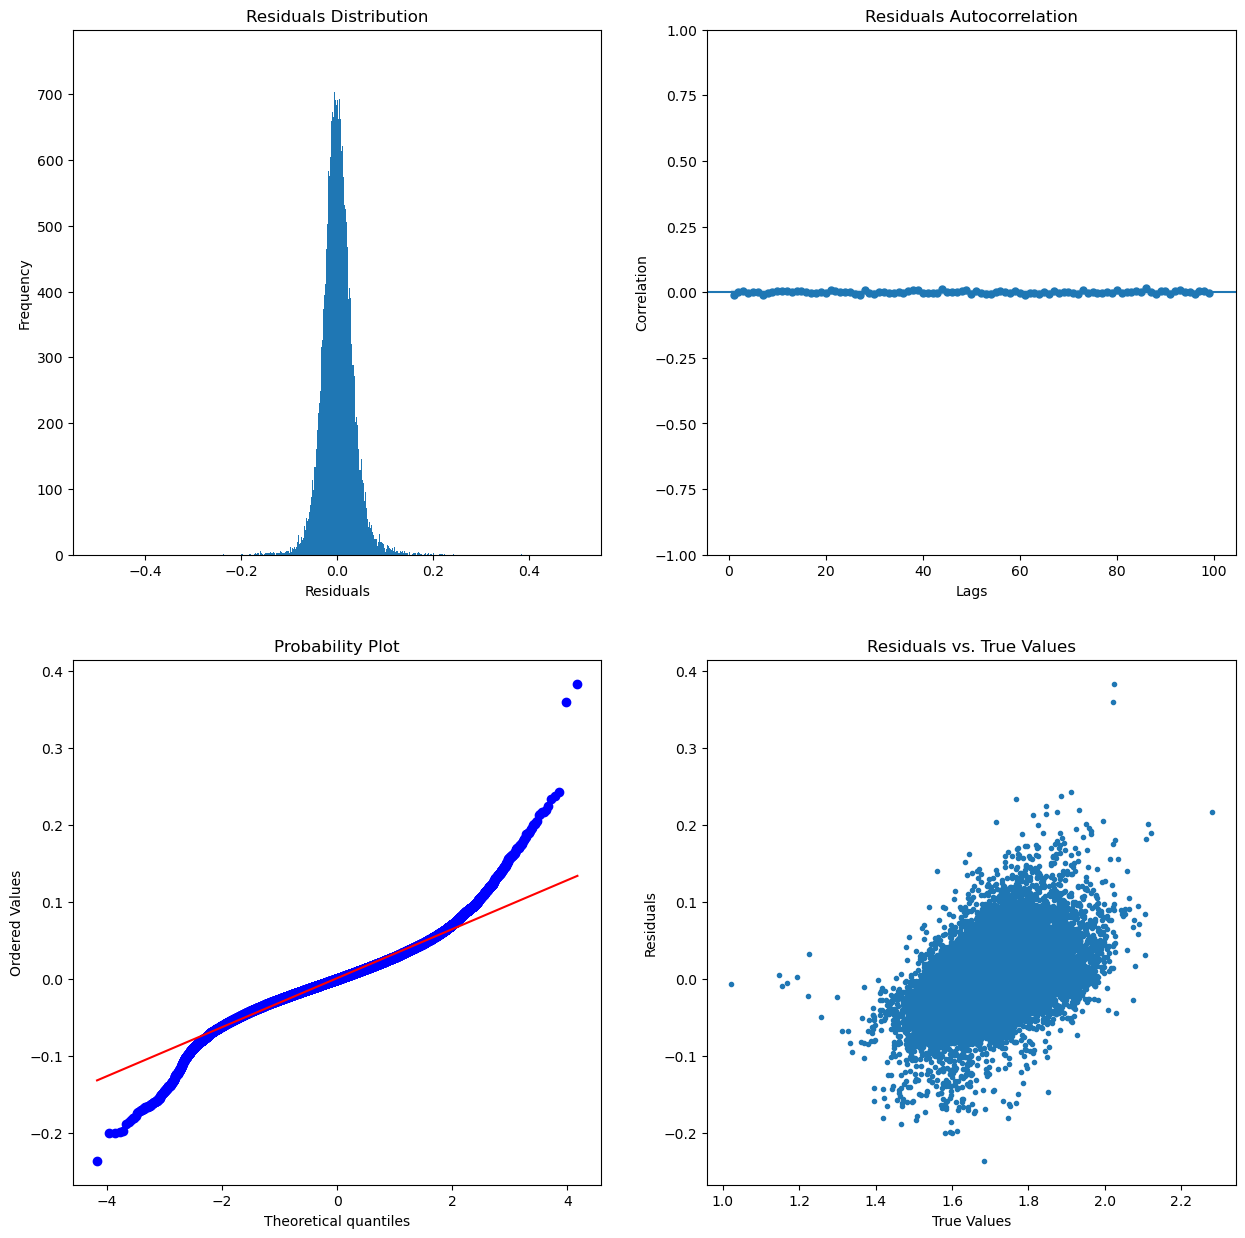

In [97]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [98]:
y_pred = np.exp(gb_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0012317268196608722
RMSE Test Set =  0.035095965860207815
MAPE Test Set =  0.014901753037755192


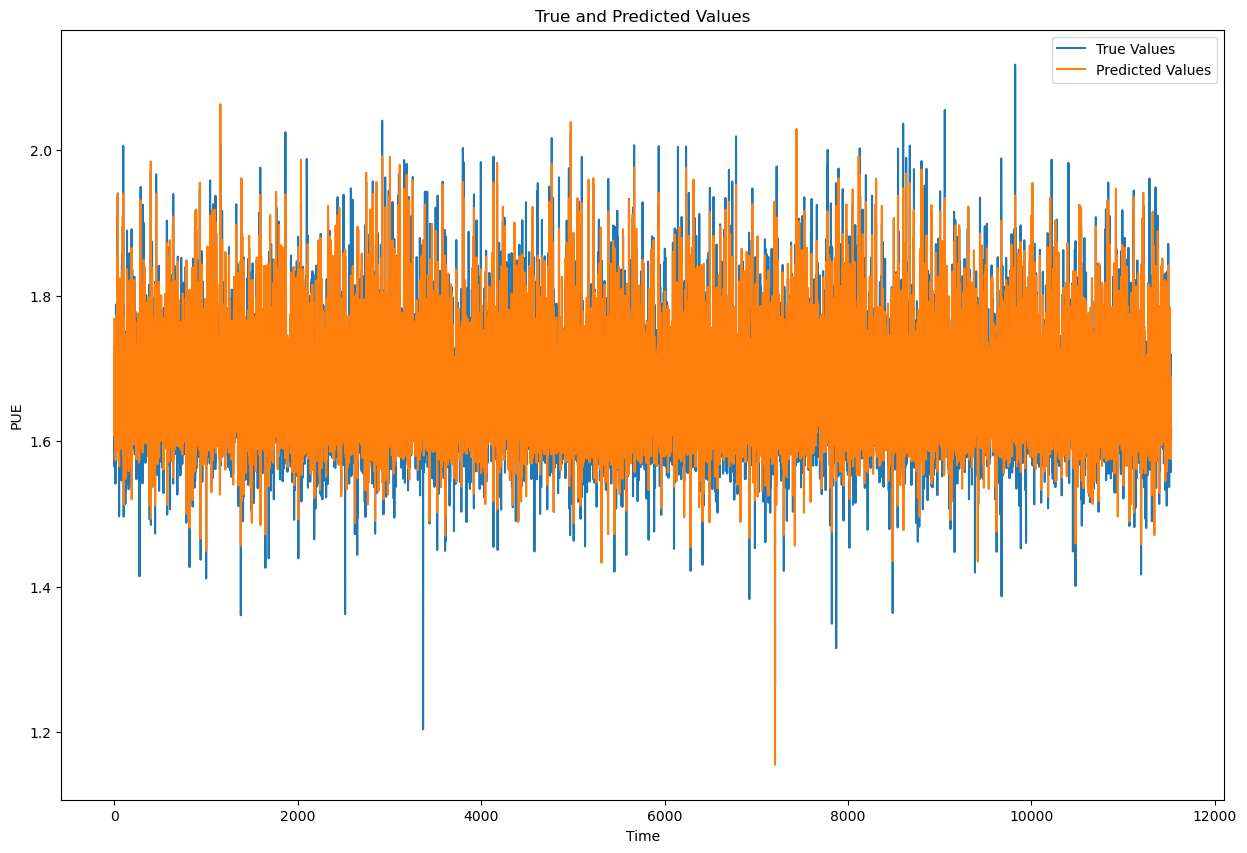

In [99]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

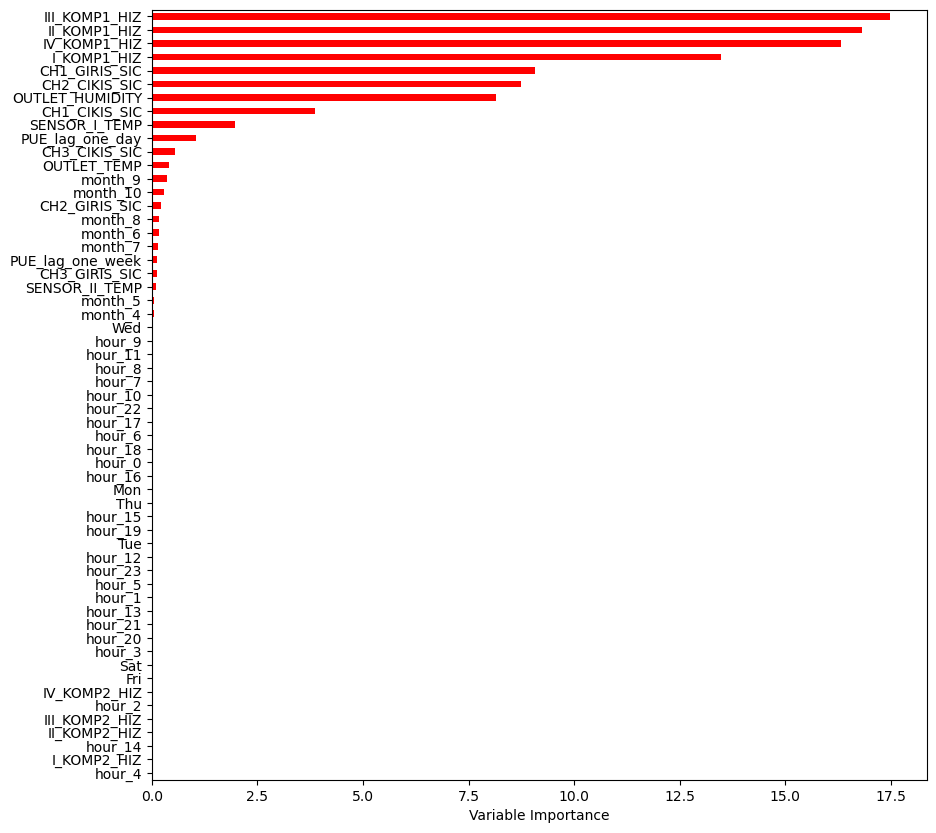

In [100]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

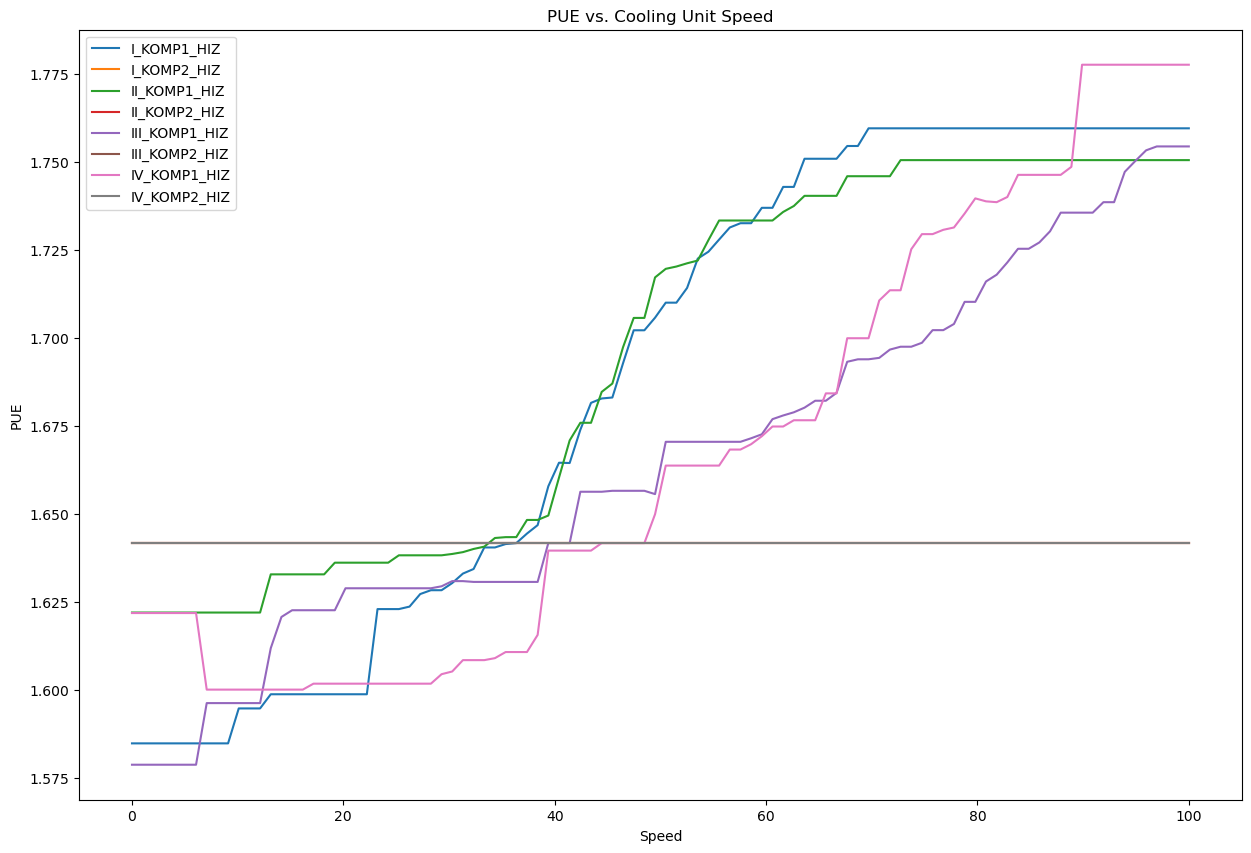

In [101]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[4][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[5][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[6][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP2_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[7][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='I_KOMP2_HIZ')
plt.plot(x,Y[2], label='II_KOMP1_HIZ')
plt.plot(x,Y[3], label='II_KOMP2_HIZ')
plt.plot(x,Y[4], label='III_KOMP1_HIZ')
plt.plot(x,Y[5], label='III_KOMP2_HIZ')
plt.plot(x,Y[6], label='IV_KOMP1_HIZ')
plt.plot(x,Y[7], label='IV_KOMP2_HIZ')
plt.title('PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

<h2>Lasso</h2>

In [ ]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))  
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [ ]:
lasso_model, predictors = lasso(alpha=0.0001)

In [ ]:
print(train.iloc[:,list(predictors+2)].columns)

In [ ]:
y_pred = np.exp(lasso_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [ ]:
y_pred = np.exp(lasso_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

In [ ]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()